## **CV|MDSE@FEUP**
### **Group:**
* Fábio Silva (202003096)
* Joana Leite (202003076)

<br>

# **Assignment 2**: Quality assurance tester of PCB Board

## *Preamble*: Load images and Python dependencies

In [ ]:
!wget -O Dataset_CV.zip https://www.dropbox.com/s/pi57lso2qcldb86/Dataset_CV.zip?dl=0 --quiet
!unzip Dataset_CV.zip -d. 

Archive:  Dataset_CV.zip
  inflating: ./Images/b1.png         
  inflating: ./Images/img2.jpg       
  inflating: ./Images/img0.jpg       
  inflating: ./Images/img1.jpg       
  inflating: ./Images/r1.png         
  inflating: ./Images/img3.jpg       
  inflating: ./Images/img4.jpg       
  inflating: ./Images/img6.jpg       
  inflating: ./Images/img5.jpg       


In [ ]:
#import cv2
#cv2.__version__
#4.1.2

In [ ]:
!pip install opencv-contrib-python==4.5.3.56

     |████████████████████████████████| 56.1 MB 1.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from google.colab.patches import cv2_imshow 
import pandas as pd
import math
from math import atan2
from matplotlib.pyplot import figure
from matplotlib import pyplot as pl
import time

In [ ]:
cv2.__version__

'4.5.3'

## Project images

In [ ]:
images_read = glob.glob('./Images/img*.jpg') 
images_read = sorted(images_read)
print(images_read)

['./Images/img0.jpg', './Images/img1.jpg', './Images/img2.jpg', './Images/img3.jpg', './Images/img4.jpg', './Images/img5.jpg', './Images/img6.jpg']


In [ ]:
# check the shape of the images
for fname in images_read:
    img = cv2.imread(fname)
    print(img.shape, ';', img.dtype)

(1846, 2600, 3) ; uint8
(1846, 2600, 3) ; uint8
(1846, 2600, 3) ; uint8
(1846, 2600, 3) ; uint8
(1846, 2600, 3) ; uint8
(1846, 2600, 3) ; uint8
(1846, 2600, 3) ; uint8


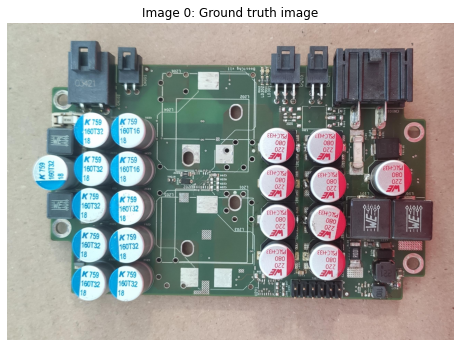


The following images are variations of the ground truth image:



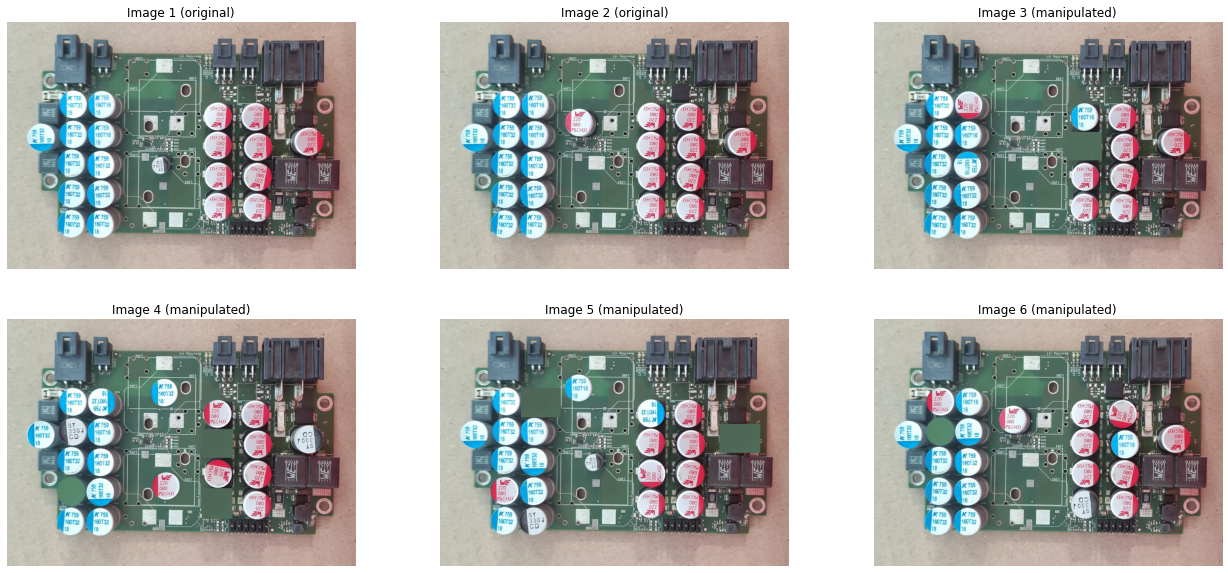

In [ ]:
original_images = []  # stores the original images
for fname in images_read:
    img = cv2.imread(fname)
    fx_resize, fy_resize = 1, 1
    img = cv2.resize(img, (0,0), fx=fx_resize, fy=fy_resize)  # if needed for faster experiments
    original_images.append(img)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(original_images[0], cv2.COLOR_BGR2RGB))
plt.title('Image 0: Ground truth image')
plt.axis('off')
plt.show()
print()
print('The following images are variations of the ground truth image:')
print()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(22, 10))
ax[0,0].imshow(cv2.cvtColor(original_images[1], cv2.COLOR_BGR2RGB))
ax[0,0].axis('off')
ax[0,0].set_title('Image 1 (original)')
ax[0,1].imshow(cv2.cvtColor(original_images[2], cv2.COLOR_BGR2RGB))
ax[0,1].axis('off')
ax[0,1].set_title('Image 2 (original)')
ax[0,2].imshow(cv2.cvtColor(original_images[3], cv2.COLOR_BGR2RGB))
ax[0,2].axis('off')
ax[0,2].set_title('Image 3 (manipulated)')
ax[1,0].imshow(cv2.cvtColor(original_images[4], cv2.COLOR_BGR2RGB))
ax[1,0].axis('off')
ax[1,0].set_title('Image 4 (manipulated)')
ax[1,1].imshow(cv2.cvtColor(original_images[5], cv2.COLOR_BGR2RGB))
ax[1,1].axis('off')
ax[1,1].set_title('Image 5 (manipulated)')
ax[1,2].imshow(cv2.cvtColor(original_images[6], cv2.COLOR_BGR2RGB))
ax[1,2].axis('off')
ax[1,2].set_title('Image 6 (manipulated)')
plt.show()

Images 0 to 2 are original images. However, to have more variations of the mistakes, same images were manipulated, namely Images 3 to 6.

## Project goal

> **The goal of this project is to detect if the target capacitors, which are the blue and red ones, are all placed at the correct location in the printed circuit board (PCB) and if the polarity is correct.**

Therefore, there are four tasks to accomplish:
1. Capacitor detection;
2. Capacitor location verification;
3. Capacitor type verification;
4. Capacitor polarity verification.

The ground truth image provides the necessary information about the correct location, type (blue or red) and polarity. In this image, it can be observed that there are 11 blue capacitors, all on the left, and 9 red capacitors, all on the right. The capacitor polarity marking is the stripe on the component, which indicates the negative lead. Thus, the polarity is correct if the stripe is aligned as in the ground truth image.

As can be seen from the images above, the camera does not change place, the lighting is similar and the possible variations are:
1. missing capacitors;
2. additional target capacitors in other locations of the PCB;
3. correct location but wrong type of capacitor;
4. correct location and type but wrong polarity;
5. additional smaller capacitors.

The variations of the ground truth are:

| Changes to the ground truth image | Image 1 | Image 2 | Image 3 | Image 4 | Image 5 | Image 6 |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|
| Missing capacitor | 0 | 0 | 1 | 3 | 2 | 1 |
| Additional capacitor | 1 (small)| 1 (big) | 0 | 2 (big) | 2 (1 small + 1 big) | 1 (big) |
| Correct location <br> Wrong type | 0 | 0 | 2 | 2 | 3 | 3 |
| Correct location <br> Correct type <br> Wrong polarity| 0 | 0 | 1 | 5 | 2 | 2 |

## Preliminary ideas

A capacitor is correct on the PCB if, cumulatively, it is at the correct location, is of the correct type and the polarity is correct. This means that the tasks do not have to be independent of each other, i.e., **a function for task can be designed on top of the previous task function and it can be assumed that it will only be applied if the output result of the previous task is the output *correct* when compared against the ground truth image**. 

Thus, given the ground truth image and a new image, the tasks were designed in the following order: 

<br>

| Task | Basis for function development | Use of ground truth (gt) image | Intended output |
|:---|:---:|:---:|:---:|
| 1. Capacitor detection | shape and size | just to determine size | circular bounding boxs (cbb) |
| 2. Capacitor location verification | coordinates of cbb | mask of gt capacitors | list of location matchs <br> between gt and new_image |
| 3. Capacitor type verification | color | range values for the colors <br> and gt colors list | list of correct types in the new_image |
| 4. Capacitor polarity verification | capacitor rotation compared to the gt <br> using key points and the homography <br> matrix to determine the rotation | gt image | list of correct polarities in the new_image |

<br>

The intended final output is an image that summarizes all this information.

**Antecipated issues:**

* **Background** - Looking at the images, capacitors have a high contrast with the background, if the background is the PCB. However, the three blue capacitors on the edges of the PCB are partially over the cardboard. In this case, the contrast is lower, which poses a problem.

* **Very near capacitors** - Some capacitors are very close to each other, especially the blue ones.

* **Polarity stripe** - polarity can be correct even if the stripe is not exactly as in the capacitor of the ground truth image in the same position. A tolerance margin has to be determined.

## Homography

A Homography is a transformation ( 3×3 matrix ) that maps the points in one image to the corresponding points in the other image. 

<br>
$H_{3,3} =
 \begin{bmatrix}
  h_{00} & h_{01} & h_{02} \\
  h_{10} & h_{11} & h_{12} \\
  h_{20} & h_{21} & h_{22}
 \end{bmatrix}$

<br>

If we consider the first set of corresponding points — ($x_{1}$, $y_{1}$) in a first image and ($x_{2}$, $y_{2}$) in a second image, then, the Homography maps them in the following way:

![alt text](https://i.stack.imgur.com/FT1K8.png)

The Homography matrix has 9 degrees of freedom, but only 8 can be calculated, because $h_{22}$ is equal to 1 to fix the coordenate reference.
<br>
It is necessary to have at least 4 pairs of points to compute the matrix. If there are more than 4 points, the matrix will be more robust. 
The points were collected from SIFT algorithm, since all the capacitors of the same type share similarities. 
<br><br>
In this project was used RANSAC (RANdom SAmple Consensus) method to estimate mathematical parameters of the homography matrix. It could have also been used LEAST_MEDIAN to estimate these parameters.
<br><br>
If the transformation between the two set of points is a scale + rotation + translation, then the homography will be an affine matrix in which the 2x2 upper-left block is a scaled rotation.In this case: <br> 
<p align="center">angle = atan2( $h[1,0]$ , $h[0,0]$ )</p> 

*Note*: atan2( y , x ) (from "2-argument arctangent") returns a single value θ such that −π < θ ≤ π.


## **1) Capacitor detection**

### 1.1) Bounding box approach: experiments

The main idea for this approach is to use the circular shape and the fixed and unique size of the target capacitors to accomplish detection.


Experiments were conducted with the Image 1, which is the same as the ground truth image but has an extra smaller capacitor.

In [ ]:
img = original_images[1].copy()

#### 1.1.1) Blurring

Blurring will help to dilute noise, and may help with the reflections and the very small shapes, making it easier to detect the bigger shapes. However, too much of it will merge the big shapes, as edges may not be preserved. Thus, a balance has to be reached.

In [ ]:
# Testing several options
kernelsize = 17
img_avg = cv2.blur(img,(kernelsize,kernelsize))
img_median = cv2.medianBlur(img, ksize=kernelsize)
img_gauss = cv2.GaussianBlur(img,(kernelsize,kernelsize),0)
img_bilat = cv2.bilateralFilter(img, d=kernelsize, sigmaColor=175, sigmaSpace=175)

print('From left to right, original image and blurred images with the average, median, Gaussian and bilateral filters')
hsep = np.ones((img.shape[0],50,3), dtype=int)*255
cv2_imshow(np.concatenate((img, hsep, img_avg, hsep, img_median, hsep, img_gauss, hsep, img_bilat), axis=1))

Output hidden; open in https://colab.research.google.com to view.

To select the best filter for this purpose, the focus was on edge preservation. According to this criterion, it can be seen from the images above that the worst performing filter is the average filter and next the median filter. The Gaussian and the bilateral filters have, apparently, the same result, but a closer look shows that, the bilateral filter does a best job at preserving edges. The results are the expected ones, given the characteristics of the filters. Thus, for the next step the option is the **bilateral filter**.

In [ ]:
# Blurring option
img_blur = img_bilat

#### 1.1.2) Binary mask

Usually, the binary mask is obtained from the gray scale image. For this project, an **alternative approach** is tested, namely **using the HSV channels**.

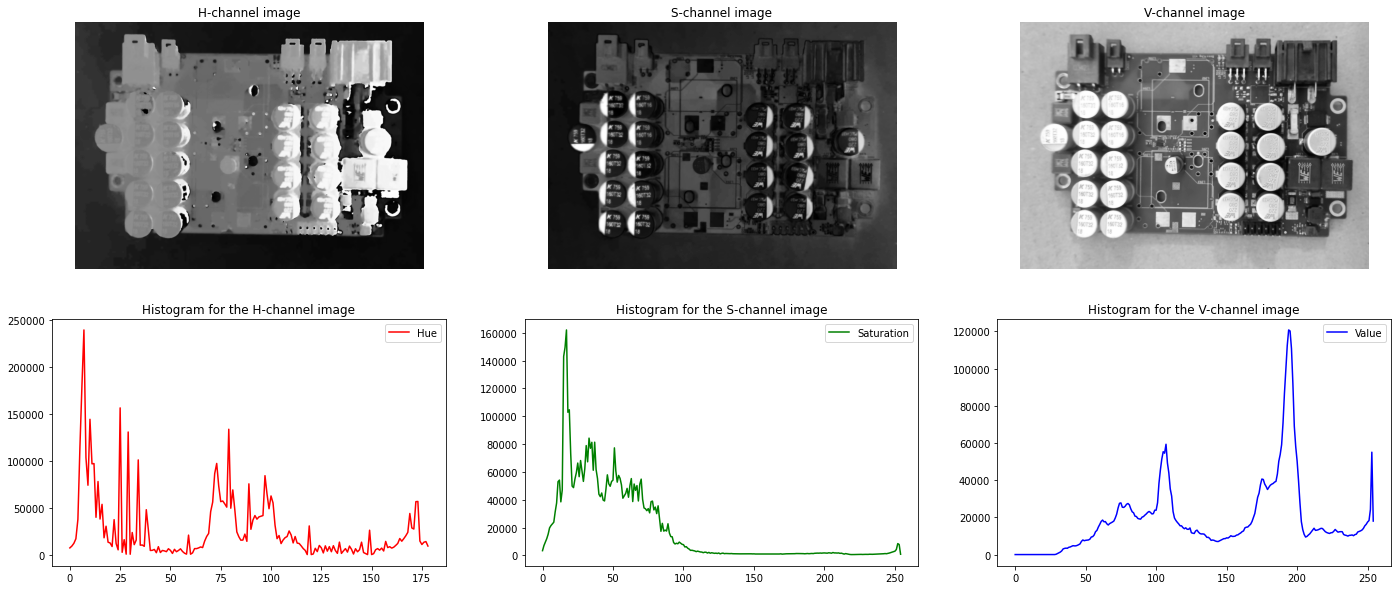

In [ ]:
# Preliminary steps for the binary image using HSV channels

img2 = cv2.cvtColor(img_blur, cv2.COLOR_BGR2HSV)
h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]

hist_h = cv2.calcHist([h],[0],None,[179],[1,180])
hist_s = cv2.calcHist([s],[0],None,[255],[1,256])
hist_v = cv2.calcHist([v],[0],None,[255],[1,256])

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 10))
ax[0,0].imshow(h, cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('H-channel image')
ax[0,1].imshow(s, cmap='gray')
ax[0,1].axis('off')
ax[0,1].set_title('S-channel image')
ax[0,2].imshow(v, cmap='gray')
ax[0,2].axis('off')
ax[0,2].set_title('V-channel image')
ax[1,0].plot(hist_h, color='r', label='Hue')
ax[1,0].legend()
ax[1,0].set_title('Histogram for the H-channel image')
ax[1,1].plot(hist_s, color='g', label='Saturation')
ax[1,1].legend()
ax[1,1].set_title('Histogram for the S-channel image')
ax[1,2].plot(hist_v, color='b', label='Value')
ax[1,2].legend()
ax[1,2].set_title('Histogram for the V-channel image')
plt.show()

From the three channels, the **V-channel** is the most promising, as it seems to enhance contrast.

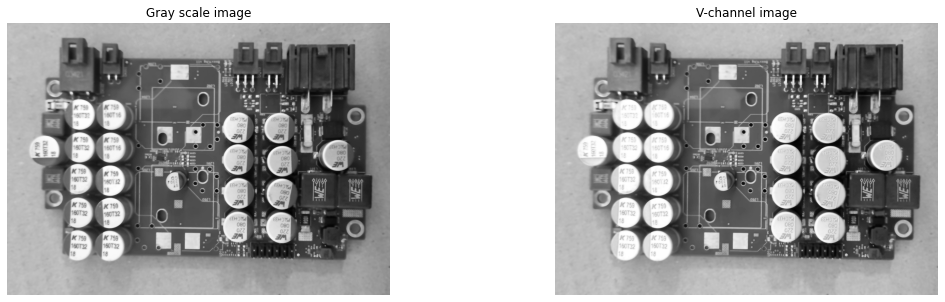

In [ ]:
gray = cv2.cvtColor(img_blur,cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
ax[0].imshow(gray, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Gray scale image')
ax[1].imshow(v, cmap='gray')
ax[1].axis('off')
ax[1].set_title('V-channel image')
plt.show()

Comparing the gray scale image with the V-channel image, we can see that the latter has an higher contrast between the capacitors and the PCB, which is more interasting for binarization.

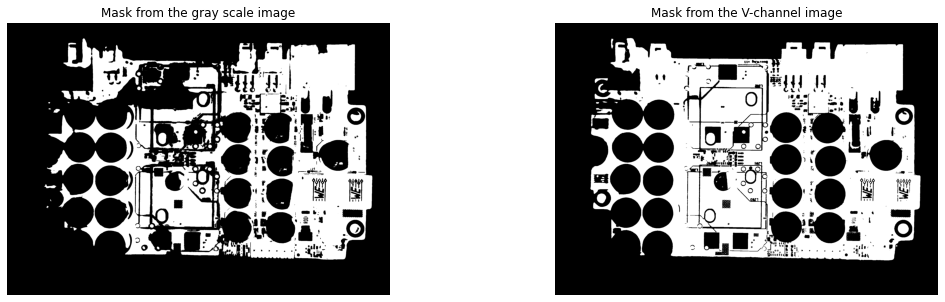

In [ ]:
_, bw_from_gray = cv2.threshold(gray, 100, 2525, cv2.THRESH_BINARY_INV)
_, bw_from_v_channel = cv2.threshold(v, 140, 255, cv2.THRESH_BINARY_INV)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
ax[0].imshow(bw_from_gray, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Mask from the gray scale image')
ax[1].imshow(bw_from_v_channel, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Mask from the V-channel image')
plt.show()

The thresholds for both masks above were set so that the right side of the PCB edge is well defined. By comparing the two images, we can clearly see that the **V-channel binarization** is the most promising. Now, it is just a matter of **finding the best threshold** so that all capacitors, including the three on the edges, form well defined circles.

From left to right, threshold set at 150, 160, 170, 180 and 190


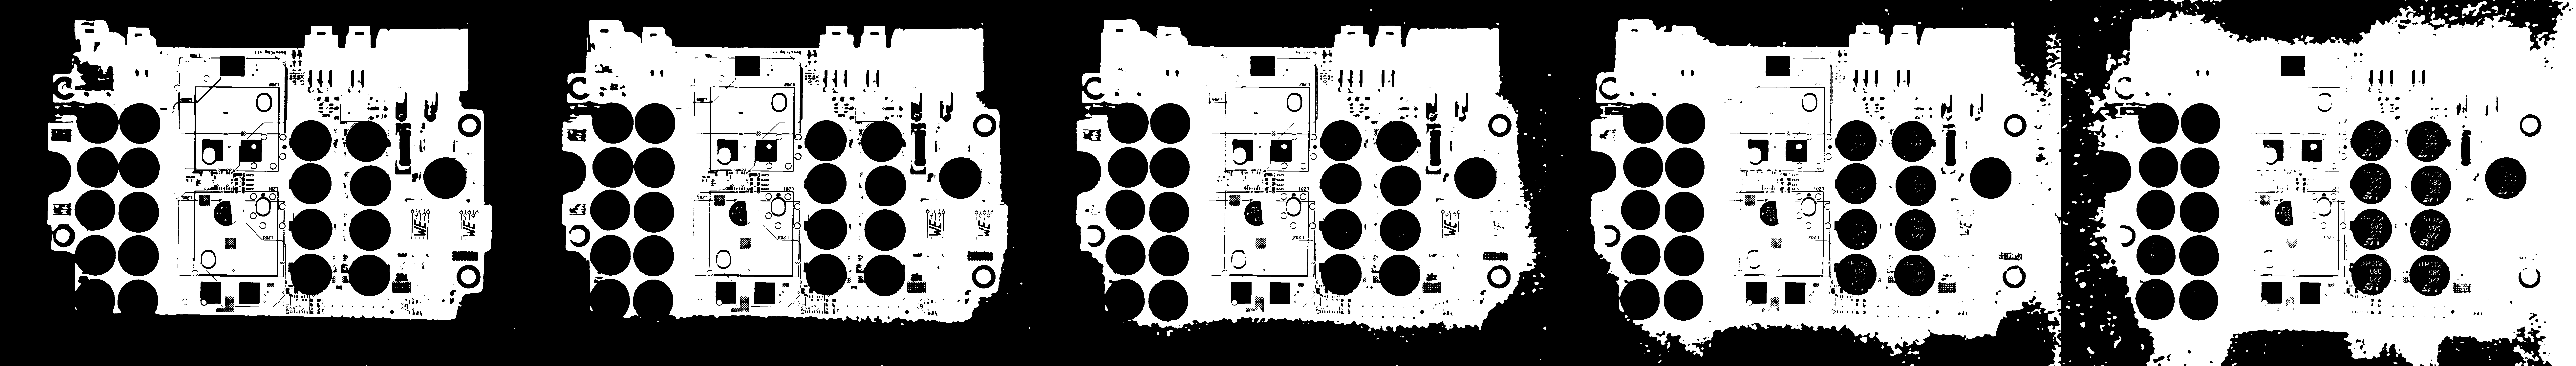


From left to right, threshold set at 200, 210, 220, 230 and 240


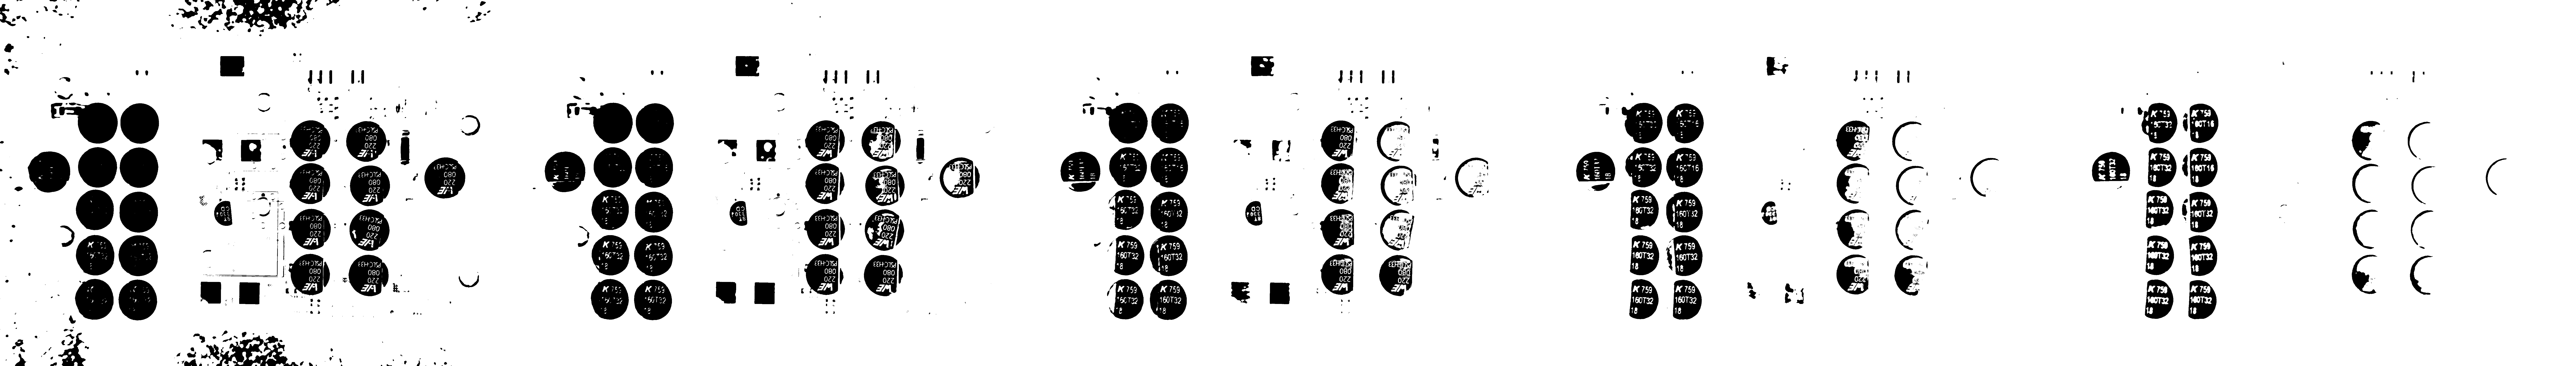

In [ ]:
# Finding the best threshold
# Threshold between 150 and 240, with 10 unit steps
print('From left to right, threshold set at 150, 160, 170, 180 and 190')
threshold_start = 150
all_img_threshold = [cv2.threshold(v, threshold_start+i*10, 255, cv2.THRESH_BINARY_INV) for i in range(5)]
all_img_threshold_concat = np.concatenate([all_img_threshold[i][1] for i in range(5)], axis=1)
cv2_imshow(all_img_threshold_concat)
print()
print('From left to right, threshold set at 200, 210, 220, 230 and 240')
threshold_start = 200
all_img_threshold = [cv2.threshold(v, threshold_start+i*10, 255, cv2.THRESH_BINARY_INV) for i in range(5)]
all_img_threshold_concat = np.concatenate([all_img_threshold[i][1] for i in range(5)], axis=1)
cv2_imshow(all_img_threshold_concat)

From left to right, threshold set at 200, 201, 202, 203 and 204


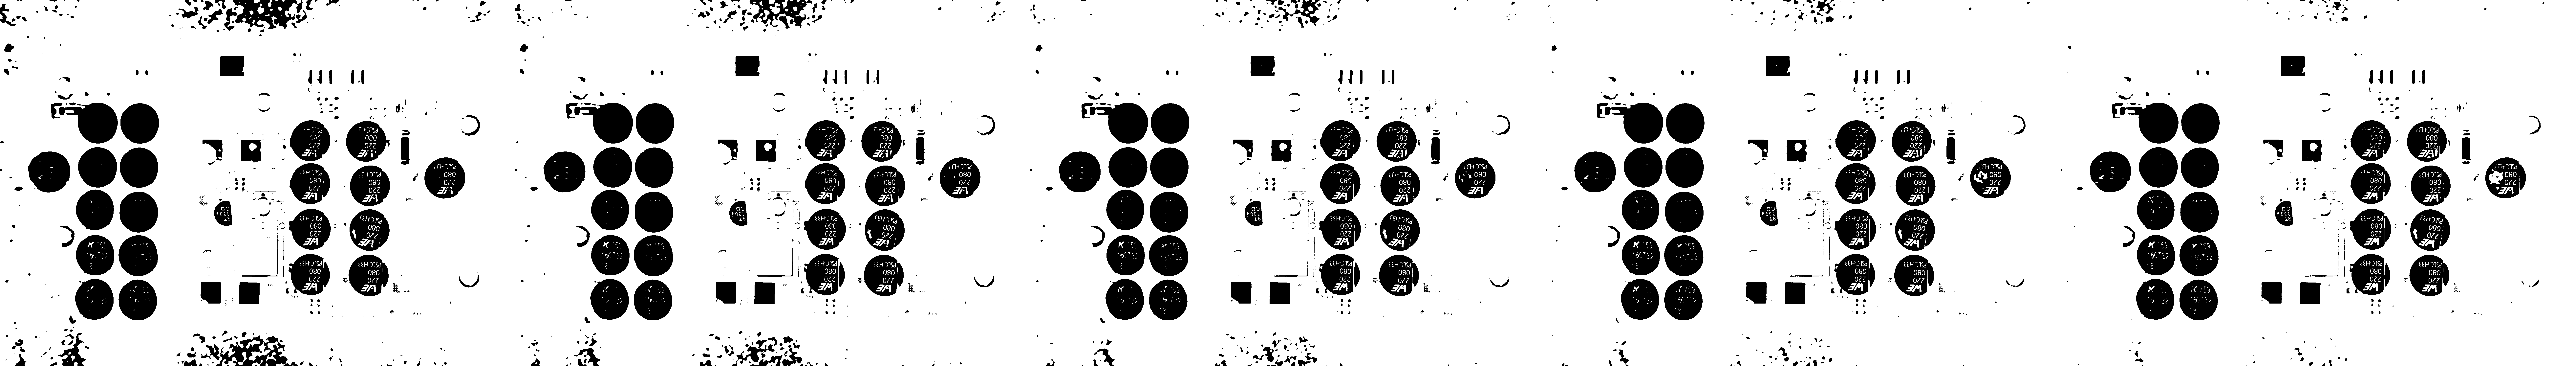

In [ ]:
# Refining the threshold
# Threshold between 200 and 204, with 1 unit steps
print('From left to right, threshold set at 200, 201, 202, 203 and 204')
threshold_start = 200
all_img_threshold = [cv2.threshold(v, threshold_start+i, 255, cv2.THRESH_BINARY_INV) for i in range(5)]
all_img_threshold_concat = np.concatenate([all_img_threshold[i][1] for i in range(5)], axis=1)
cv2_imshow(all_img_threshold_concat)

The threshold selected was 204, as the circles of all blue and red capacitors are well defined and the noise is reduced. It is interesting to notice that the smaller capacitor is also preserved.

In [ ]:
img_mask = cv2.threshold(v, 204, 255, cv2.THRESH_BINARY_INV)[1]

#### 1.1.3) Edge detectors

The objective is now to enhance the edges. Both Canny and Sobel edge detectores were tested.

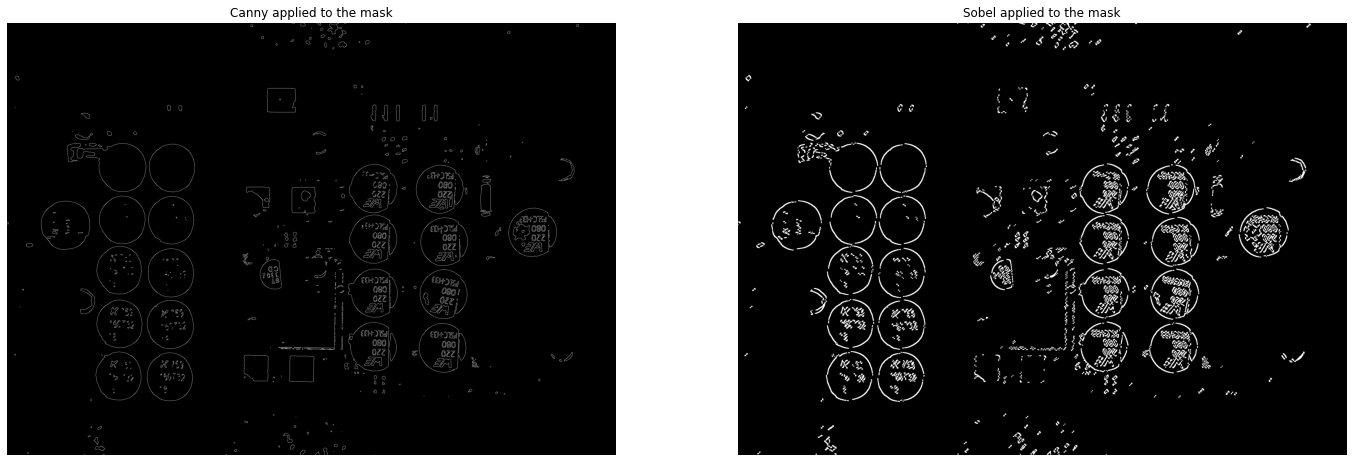

In [ ]:
img_canny = cv2.Canny(img_mask, 50, 130)
img_sobel = cv2.Sobel(img_mask, ddepth=cv2.CV_8UC1, dx=1, dy=1, ksize=9)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))
ax[0].imshow(img_canny, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Canny applied to the mask')
ax[1].imshow(img_sobel, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Sobel applied to the mask')
plt.show()

For this purpose, Sobel produced poorer results than Canny. Thus, Canny was chosen.

In [ ]:
img_edge = img_canny

#### 1.1.4) Circular bounding boxs

For the shape detection, since all capacitor are circles when viewed from above, then the bounding box used was the one that generates circles, specifically, `cv2.HoughCircles()`.

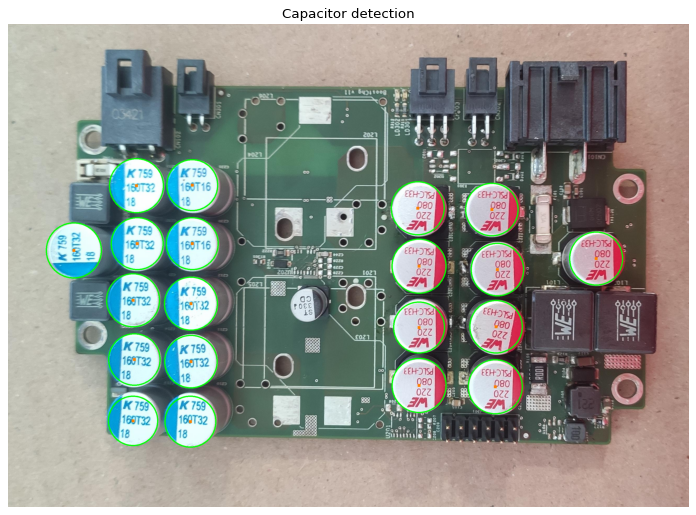

Number of capacitors detected: 20


In [ ]:
circles = cv2.HoughCircles(img_edge, cv2.HOUGH_GRADIENT, dp = 2.6 , minDist = 110, minRadius = 90, maxRadius = 110)
circles = np.round(circles[0, :]).astype("int")

img_copy = img.copy()

# loop over the (x, y) coordinates and radius of the circles
for (x, y, r) in circles:
	# draw the circle in the output image, then draw a rectangle
	# corresponding to the center of the circle
	cv2.circle(img_copy, (x, y), r, (0, 255, 0), 4)
	cv2.rectangle(img_copy, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

# show the output image
#cv2_imshow(img_copy)

plt.figure(figsize=(18, 8), dpi=80)
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.title('Capacitor detection')
plt.axis('off')
plt.show()
print('Number of capacitors detected:', len(circles))

The circles outputted by the function `cv2.HoughCircles()` do not have an intelligible ordering. Although it is not mandary, it is easier to work if the capacitors appear in an order that makes sense to the user. An intuitive ordering is from left to right and, if in column, from top to bottom.

In [ ]:
# Sort the circles (defined by (x,y,r)) from left to right (with x) and top to bottom (with y)
# To accomplish this, when several x values are very close, the circles are sorted by the y value

circle_list_copy = circles.copy()
# first, sort by x
circles_sorted = circle_list_copy[np.argsort(circle_list_copy[:,0])]
i=0
while i < len(circles_sorted):
    aux_circles_sorted = circles_sorted[i,:]
    if i < len(circles_sorted)-1:
        for j in range(i+1,len(circles_sorted)):
            if circles_sorted[j,0] > circles_sorted[i,0]+50:
                aux_circles_sorted = np.concatenate([circles_sorted[k,:] for k in range(i,j)]).reshape(j-i,3)
                # now, sort by y
                aux_circles_sorted = aux_circles_sorted[np.argsort(aux_circles_sorted[:,1])]
                circles_sorted[i:j,] = aux_circles_sorted
                i = j
                del(aux_circles_sorted)
                break
            elif j == len(circles_sorted)-1:
                aux_circles_sorted = np.concatenate([circles_sorted[k,:] for k in range(i,j+1)]).reshape(j-i+1,3)
                # now, sort by y
                aux_circles_sorted = aux_circles_sorted[np.argsort(aux_circles_sorted[:,1])]
                circles_sorted[i:j+1,] = aux_circles_sorted
                i = j
    else:
        circles_sorted[i,] = aux_circles_sorted
        del(aux_circles_sorted)
        break

df = pd.DataFrame(data=np.concatenate((circles,circles_sorted), axis=1),
                  columns=['original_col1','original_col2','original_col3','sorted_col1','sorted_col2','sorted_col3'])
df
# To fully understand the ordering, look at the sorted columns, for example, rows 1 to 5.
# In those rows, the values in sorted_col1 are very close, meaning that the circles are 
# form a column, thus the sorted values are in sorted_col2, so that the sort is from top
# to bottom.

original_col1  original_col2  ...  sorted_col2  sorted_col3
0            1847            711  ...          867          105
1             493            841  ...          620          103
2            1863           1158  ...          841           99
3             490            620  ...         1057          101
4             251            867  ...         1283           98
5            2245            898  ...         1517           94
6             703            618  ...          618           97
7            1569            927  ...          841           99
8             698           1070  ...         1070          101
9            1860           1387  ...         1291          100
10            698           1291  ...         1520           97
11            482           1283  ...          706          101
12           1569           1161  ...          927          103
13            477           1517  ...         1161           97
14           1564            706  ...         1382          103
15           1569           1382  ...          711          100
16            696           1520  ...          940          100
17            703            841  ...         1158          100
18            477           1057  ...         1387          103
19           1868            940  ...          898          101

[20 rows x 6 columns]

### 1.2) Task functions

All the previous steps are now summarized in following three functions.

#### `circle_sort()`


In [ ]:
def circle_sort(circle_list):
    """
    For sorting a list of the circles (defined by (x,y,r)) from left to right (with x) and top to bottom (with y).
    To accomplish this, when several x values are very close, the circles are sorted by the y value.
    * Input: numpy array with, at least, two columns.
    * Return: sorted input (thus, same type and shape of the input).
    """
    data_list_copy = circle_list.copy()
    # first, sort by x
    data_sorted = data_list_copy[np.argsort(data_list_copy[:,0])]
    # if needed, sort by y
    i = 0
    while i < len(data_sorted):
        aux_data_sorted = data_sorted[i,:]
        if i < len(data_sorted)-1:
            for j in range(i+1,len(data_sorted)):
                if data_sorted[j,0] > data_sorted[i,0]+50:
                    aux_data_sorted = np.concatenate([data_sorted[k,:] for k in range(i,j)]).reshape(j-i,3)
                    # now, sort by y
                    aux_data_sorted = aux_data_sorted[np.argsort(aux_data_sorted[:,1])]
                    data_sorted[i:j,] = aux_data_sorted
                    i = j
                    del(aux_data_sorted)
                    break
                elif j == len(data_sorted)-1:
                    aux_data_sorted = np.concatenate([data_sorted[k,:] for k in range(i,j+1)]).reshape(j-i+1,3)
                    # now, sort by y
                    aux_data_sorted = aux_data_sorted[np.argsort(aux_data_sorted[:,1])]
                    data_sorted[i:j+1,] = aux_data_sorted
                    i = j
        else:
            data_sorted[i,] = aux_data_sorted
            del(aux_data_sorted)
            break
    return data_sorted

#### `circular_bb_detection()`


In [ ]:
def circular_bb_detection(image, minRad=90, maxRad=110):
    """
    For detecting capacitors with a circular bounding box (cbb).
    * Input: 3-channel image and, optionally, the minimum and maximum radius for the cbb.
    * Return: count of circles (i.e. number of detected capacitors), sorted list of cbb circles, 
    and the 3-channel image with the circles drawn.
    """
    # original image copy so that the circular bounding boxes can be added without altering it
    image_copy = image.copy() 
    image_blur = cv2.bilateralFilter(image_copy, d=17, sigmaColor=175, sigmaSpace=175)
    image_v = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)[:,:,2]
    image_mask = cv2.threshold(image_v, 204, 255, cv2.THRESH_BINARY_INV)[1]
    image_edge = cv2.Canny(image_mask, 50, 130)
    circles = cv2.HoughCircles(image_edge, cv2.HOUGH_GRADIENT, dp = 2.5 , minDist = 110, minRadius = minRad, maxRadius = maxRad)
    circles = np.round(circles[0, :]).astype("int")
    return len(circles), circle_sort(circles)

#### `circular_bb_display()`

In [ ]:
def circular_bb_display(image, minRad=90, maxRad=110, fig_size=(18, 8)):
    """
    For exhibiting the capacitors in an image.
    * Input: 3-channel image and, optionally, the minimum and maximum radius for the cbb.
    * Output: The input 3-channel image is outputted with the circular bounding boxs, 
    each showing the number assigned to it.
    """
    image_circles = image.copy()
    n_capacitors, circles = circular_bb_detection(image_circles)
    for index, (x, y, r) in enumerate(circles):
        cv2.circle(image_circles, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(image_circles, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
        cv2.putText(image_circles, str(index), (circles[index,0],circles[index,1]), cv2.FONT_HERSHEY_SIMPLEX, 2.2, (0, 0, 0), 8)
    plt.figure(figsize=fig_size, dpi=80)
    plt.imshow(cv2.cvtColor(image_circles, cv2.COLOR_BGR2RGB))
    plt.title('Capacitor detection (first stage)')
    plt.axis('off')
    plt.show()
    print('Number of capacitors detected:', n_capacitors)

Below, the function `circular_bb_display()` is tested with Image 2, which is a different image from the experiments above. This Image 2 has an additional red capacitor at the center of the PCB, with index 11.

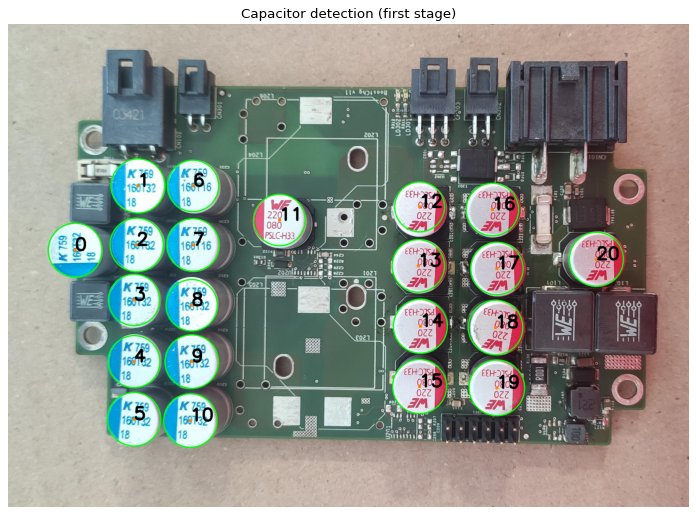

Number of capacitors detected: 21


In [ ]:
circular_bb_display(original_images[2])

## **2) Capacitor location verification**

For the location verification, the first step is obtaining the masks for the capacitors that were detected using the circles that define the circular bounding boxs.

#### `capacitor_mask()`



In [ ]:
def capacitor_mask(image, minRad=90, maxRad=110):
    """
    For producing a mask using the all circles obtained for detection.
    * Input: 3-channel image and, optionally, the minimum and maximum radius for the cbb.
    * Return: global capacitor mask and, for convenience, the list of cbb circles.
    """
    circles = circular_bb_detection(image)[1]
    location_mask = np.zeros((image.shape[0],image.shape[1]), dtype=np.uint8)
    for (x, y, r) in circles:
        cv2.circle(location_mask, (x, y), r, (1,1,1), -1)
    return location_mask, circles

#### `capacitor_mask_list()`

In [ ]:
def capacitor_mask_list(image, minRad=90, maxRad=110):
    """
    For producing a mask for each of the individual detected capacitors.
    * Input: 3-channel image and, optionally, the minimum and maximum radius for the cbb.
    * Return: list of all the individual masks and, for convenience, list of cbb circles.
    """
    circles = circular_bb_detection(image)[1]
    location_mask_list = []
    for (x, y, r) in circles:
        location_mask = np.zeros((image.shape[0],image.shape[1]), dtype=np.uint8)
        cv2.circle(location_mask, (x, y), r, (1,1,1), -1)
        location_mask_list.append(location_mask)
    return location_mask_list, circles

Below, capacitor masks produced with the above functions are shown for the **ground truth image**.

In [ ]:
img_ground_truth = original_images[0].copy()

img_gt_full_mask = capacitor_mask(img_ground_truth)[0]
img_gt_mask_list = capacitor_mask_list(img_ground_truth)[0]

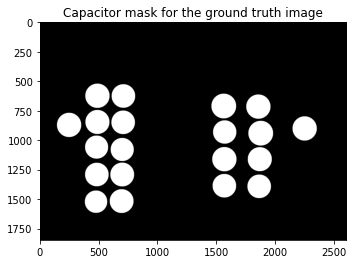

In [ ]:
plt.imshow(img_gt_full_mask, cmap='gray')
plt.title('Capacitor mask for the ground truth image')
plt.show()

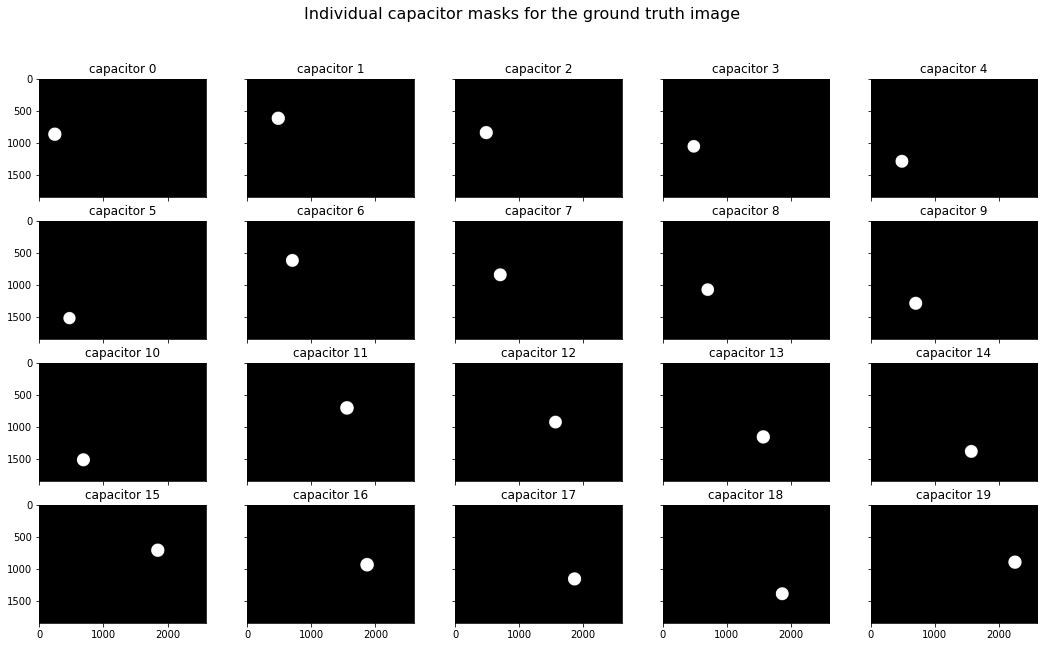

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(18, 10), sharex=True, sharey=True)
for i in range(4):
    for j in range(5):
        ax[i,j].imshow(img_gt_mask_list[i*5+j], cmap='gray')
        ax[i,j].set_title('capacitor ' + str(i*5+j))
fig.suptitle('Individual capacitor masks for the ground truth image', fontsize=16)
plt.show()

To now match the capacitors in the ground truth image with the ones in a new image, the individual capacitor masks of each image have to be compared.

#### `matching_gt_with_image()`

In [ ]:
def matching_gt_with_image(gt_mask_list, image, minRad=90, maxRad=110):
    """
    For mapping the ground truth capacitors with the new image capacitors.
    * Input: ground truth list of individual capacitor masks and 3-channel image
    and, optionally, the minimum and maximum radius for the cbb.
    * Returns:
    - list of matched of indexes between the ground truth and the new image, 
    which forms a list of pairs (index_gt,index_new_image);
    - list of individual capacitor masks for the new image for convenience;
    - list of bounding box circles for the new image for convenience;
    - list of unmatched ground truth capacitor indexes for convenience;
    - list of unmatched new image capacitor indexes for convenience.
    """
    image_copy = image.copy()
    capacitors_gt_match = []  # stores the matches
    capacitors_only = capacitor_mask(image_copy)[0]
    capacitors_only_list, circles = capacitor_mask_list(image_copy)
    index_list_to_test = list(range(len(capacitors_only_list)))
    index_gt_unmatched = []
    # j is the index for capacitors on the new image
    j=0
    # i is the index for capacitors on the ground truth image
    for i in range(len(gt_mask_list)):
        # check if there is an intersection of the new image with capacitor index i
        # of the ground truth image by determining the area of the intersected masks
        mask_detect_gt = cv2.bitwise_and(capacitors_only, capacitors_only, mask=gt_mask_list[i])
        mask_area = np.sum(mask_detect_gt)
        # if the area is significative, find the matching capacitor index j of the 
        # new image by going over the remaining index_list_to_test
        if mask_area>10000:
            while j in index_list_to_test:
                match_gt = cv2.bitwise_and(mask_detect_gt, mask_detect_gt, mask=capacitors_only_list[j])
                match_area = np.sum(match_gt)
                j += 1
                if match_area>10000:
                    capacitors_gt_match.append([i,j-1])
                    index_list_to_test.remove(j-1)
                    break
        else:
            index_gt_unmatched.append(i)
    return capacitors_gt_match, capacitors_only_list, circles, index_gt_unmatched, index_list_to_test

Below, the function `matching_gt_with_image()` is tested with Image 2, which has an additional red capacitor at the center of the PCB when compared to the ground truth. In the table below, the additional capacitor in the new image, which has index 11, has no match in the ground truth. All others are correctly matched.

In [ ]:
match = matching_gt_with_image(img_gt_mask_list, original_images[2])[0]
df = pd.DataFrame(match, columns=['ground truth capacitor index','new image capacitor index'])

In [ ]:
df

ground truth capacitor index  new image capacitor index
0                              0                          0
1                              1                          1
2                              2                          2
3                              3                          3
4                              4                          4
5                              5                          5
6                              6                          6
7                              7                          7
8                              8                          8
9                              9                          9
10                            10                         10
11                            11                         12
12                            12                         13
13                            13                         14
14                            14                         15
15                            15                         16
16                            16                         17
17                            17                         18
18                            18                         19
19                            19                         20

## **3) Capacitor type verification**

The type of capacitor is, in this case, only determined by color. The target types colors in the ground truth image are only blue and red.

#### `capacitor_color()`

In [ ]:
def capacitor_color(image, mask):
    """
    For determining the color of an individual capacitor.
    * Input: 3-channel image and the mask that corresponds to the individual capacitor to analyze.
    * Return: string with the color of the analyzed capacitor ('blue' or 'red' or 'other').
    To accomplish this, the image is converted to an HSV image and only the H-channel is retained. 
    Then, the mask that corresponds to the capacitor is applied to the image.
    Finaly, the number of pixels that are in the range of the color are counted.
    """
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image_h = image_hsv[:,:,0]
    image_h_mask = cv2.bitwise_and(image_h, image_h, mask=mask)
    # blue color ranges
    lower_blue, upper_blue = 85, 100
    # red color ranges
    lower_red, upper_red = 150, 179
    # count
    blue_area = np.ma.masked_where(((image_h_mask<lower_blue)|(image_h_mask>upper_blue)), image_h_mask).count()
    red_area = np.ma.masked_where(((image_h_mask<lower_red)|(image_h_mask>upper_red)), image_h_mask).count()
    if blue_area>20000:
        return 'blue'
    elif red_area>10000:
        return 'red'
    else:
        return 'other'

#### `capacitor_color_lists()`

In [ ]:
def capacitor_color_lists(image, image_mask_list):
    """
    For producing the list of blue and also the list of red capacitors.
    * Input: 3-channel image and the list of capacitor masks of that image.
    * Return: two lists, one the blue capacitor indexes and another of the red capacitors indexes of an image.
    """
    blue_capacitors_ret = []
    red_capacitors_ret = []
    for i in range(len(image_mask_list)):
        c_color = capacitor_color(image, image_mask_list[i])
        if c_color=='blue':
            blue_capacitors_ret.append(i)
        elif c_color=='red':
            red_capacitors_ret.append(i)
    return blue_capacitors_ret, red_capacitors_ret 

The output of `capacitor_color_lists()` for the **ground truth image** and for **Image 2**.

In [ ]:
print('Ground truth image \n')
gt_blue_list, gt_red_list = capacitor_color_lists(img_ground_truth, img_gt_mask_list)
print('Blue capacitor list:', gt_blue_list)
print('Thus,', len(gt_blue_list), 'blue capacitors.')
print()
print('Red capacitor list:', gt_red_list)
print('Thus,', len(gt_red_list), 'red capacitors.')
print("________________________________________________________")
print()

print('Image 2 \n')
img_blue_list, img_red_list = capacitor_color_lists(original_images[2], capacitor_mask_list(original_images[2])[0])
print('Blue capacitor list:', img_blue_list)
print('Thus,', len(img_blue_list), 'blue capacitors.')
print()
print('Red capacitor list:', img_red_list)
print('Thus,', len(img_red_list), 'red capacitors.')
print("________________________________________________________")
print()

Ground truth image 

Blue capacitor list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Thus, 11 blue capacitors.

Red capacitor list: [11, 12, 13, 14, 15, 16, 17, 18, 19]
Thus, 9 red capacitors.
________________________________________________________

Image 2 

Blue capacitor list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Thus, 11 blue capacitors.

Red capacitor list: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Thus, 10 red capacitors.
________________________________________________________



## **4) Capacitor polarity verification**

#### `get_degree_by_sift()`

In [ ]:
def get_degree_by_sift (image1, image2):
  """
  Input: two images to compare the degrees of the capacitors. Img1 should be the reference.
  Output: Prints the capacitors of each image, the highest 4 keypoints matches and the diference of the degree between capacitors.
  Return: An angle aproximation of rotation from capacitors from image 2 to image 1, and also the integer exact angle rotation 
  """
  # Initiate SIFT detector
  sift = cv2.xfeatures2d.SIFT_create() 

  keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
  keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

  # Set parameters for Flann (these are specific for SIFT descriptors. if using ORB or another visit <link>)
  FLAN_INDEX_KDTREE = 0
  index_params = dict (algorithm = FLAN_INDEX_KDTREE, trees=5)
  search_params = dict (checks=50)

  # Initiate Flann Matcher
  flann = cv2.FlannBasedMatcher(index_params, search_params)

  # Compute matches
  matches = flann.knnMatch(descriptors1, descriptors2, k=2)

  good_matches = []
  good_matches_list = []    
  ratio = 0.7
  for m1, m2 in matches:
    if m1.distance < ratio * m2.distance:
      good_matches.append(m1)
      good_matches_list.append([m1])

  n_good_matches = sorted(good_matches_list, key = lambda x:x[0].distance, reverse=False)

  #flann_matches =cv2.drawMatchesKnn(image1, keypoints1, image2, keypoints2, n_good_matches[:4], None, flags=2)
  #cv2_imshow(flann_matches)
  #print("\n")

  src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

  H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
  angle =  math.degrees(math.atan2(H[1,0], H[0,0]))

  if angle < 0:
    angle = angle + 360       # make degree always positive 

  if angle >= 45 and angle < 135:
    angle_return = 90
  elif angle >= 135 and angle < 225:
    angle_return = 180
  elif angle >= 225 and angle < 315:
    angle_return = 270
  else:
    angle_return = 0
  
  return angle_return, int(angle)

#### `croped_capacitor()`

In [ ]:
def croped_capacitor (image, mask, circle_tuple):
  """
  Input: Image and mask and a tuple of cicle info. The tuple has (coordinate x, coordinate y, radious)
  Return: Croped capacitor
  """
  x1 = circle_tuple[0]
  y1 = circle_tuple[1]
  r1 = circle_tuple[2]

  # the mask is used only to remove the background
  mask_img = mask[y1-r1:y1+r1+1,x1-r1:x1+r1+1]
  img1_recort = image[y1-r1:y1+r1+1,x1-r1:x1+r1+1].copy()

  croped_image = cv2.bitwise_and(img1_recort, img1_recort, mask = mask_img)
  
  return croped_image

#### `croped_capacitor_list()`

In [ ]:
def croped_capacitor_list (image, list_of_masks, circles_tuple):
  """
  Input: Image and a list of masks (each mask means a capacitor) and a tuple of cicles info. The tuple has (coordinate x, coordinate y, radious)
  Return: A list of images that only have a croped capacitor
  """
  List_of_capacitors = []
  for i in range(len(list_of_masks)):
    x1 = circles_tuple[i][0]
    y1 = circles_tuple[i][1]
    r1 = circles_tuple[i][2]

    # the mask is used only to remove the background
    mask_img = list_of_masks[i][y1-r1:y1+r1+1,x1-r1:x1+r1+1]
    img1_recort = image[y1-r1:y1+r1+1,x1-r1:x1+r1+1].copy()

    new_img = cv2.bitwise_and(img1_recort, img1_recort, mask = mask_img)
    List_of_capacitors.append(new_img)
  
  return List_of_capacitors

### 4.1) Compare between 2 different images

#### `compare_degrees_capacitor()`

In [ ]:
def compare_degrees_capacitor(img1,img2):
  """
  Input: two images to compare the degrees of the capacitors. Img1 should be the reference
  Return: List of tuples where (index of cap in image 1, index of cap in image 2, (angle, angle integer) )
  """
  list_masks_img1, circles_img1 = capacitor_mask_list( img1 ) 
  match, list_masks_img2, circles_img2, _, _ = matching_gt_with_image(list_masks_img1, img2)

  capacitors_image1 = croped_capacitor_list(img1, list_masks_img1, circles_img1)
  capacitors_image2 = croped_capacitor_list(img2, list_masks_img2, circles_img2)

  qt_cap_blue_img1, qt_cap_red_img1 = capacitor_color_lists( img1, list_masks_img1 )
  qt_cap_blue_img2, qt_cap_red_img2 = capacitor_color_lists( img2, list_masks_img2 )
  print("\n")

  degrees = []
  for i in match:
    idx1, idx2 = i[0], i[1]
    #print("Index", idx1, idx2)
    degree = get_degree_by_sift( capacitors_image1[idx1] , capacitors_image2[idx2] )
    #print("Degree rotation", degree[0], "\n")
    degrees.append((idx1, idx2, degree))
  
  return degrees

In [ ]:
img1 = original_images[0] #cv2.imread("./Images/img1.jpg")  # ground truth
img2 = original_images[2] #cv2.imread("./Images/img3.jpg")  # to compare
degrees = compare_degrees_capacitor(img1, img2)

In [ ]:
degrees

[(0, 0, (0, 359)),
 (1, 1, (0, 0)),
 (2, 2, (0, 0)),
 (3, 3, (0, 359)),
 (4, 4, (0, 359)),
 (5, 5, (0, 359)),
 (6, 6, (0, 359)),
 (7, 7, (0, 359)),
 (8, 8, (0, 0)),
 (9, 9, (0, 0)),
 (10, 10, (0, 0)),
 (11, 12, (0, 0)),
 (12, 13, (0, 0)),
 (13, 14, (0, 0)),
 (14, 15, (0, 0)),
 (15, 16, (0, 0)),
 (16, 17, (0, 359)),
 (17, 18, (0, 0)),
 (18, 19, (0, 0)),
 (19, 20, (0, 0))]

### 4.2) Get degrees of capacitors

#### `degrees_capacitor()`

In [ ]:
def degrees_of_capacitors (image_to_get_degrees, img_ref_blue, img_ref_red ):
  """
  Input: Image to take degrees of the capacitors. An image that is the 0 degree reference for blue capacitor and also a reference for the red capacitors.
  Output: Prints the capacitors of each image, the highest 4 keypoints matches and the degree compared to each reference.
  Return: Two lists of tuples with the degrees of the blue capacitors and red capacitors. Tuple (index, degree and integer degree) 
  """
  list_masks_img1, circles_img1 = capacitor_mask_list( img1 ) 
  capacitors_image1 = croped_capacitor_list(img1, list_masks_img1, circles_img1)
  qt_cap_blue_img1, qt_cap_red_img1 = capacitor_color_lists( img1, list_masks_img1 )
  print("\n")

  # lists have tuple. (aproximate degree, integer degree)
  list_degrees_blue = []  
  list_degrees_red = []

  for i in qt_cap_blue_img1:
    degree = get_degree_by_sift( img_ref_blue , capacitors_image1[i] )
    #print("Degree rotation", degree[0], "\n")
    list_degrees_blue.append((i,degree[0],degree[1]))

  for i in qt_cap_red_img1:
    degree = get_degree_by_sift( img_ref_red , capacitors_image1[i] )
    #print("Degree rotation", degree[0], "\n")
    list_degrees_red.append((i, degree[0],degree[1]))
  
  return list_degrees_blue, list_degrees_red

In [ ]:
img1 = original_images[0] #cv2.imread("./Images/img1.jpg")   # to get degrees according to referenced image 1
img2 = cv2.imread("./Images/b1.png")            # image with 0 degrees for blues
img3 = cv2.imread("./Images/r1.png")            # image with 0 degrees for reds

degrees_blue, degrees_red = degrees_of_capacitors (img1, img2, img3)

In [ ]:
degrees_blue

[(0, 270, 271),
 (1, 180, 179),
 (2, 180, 175),
 (3, 180, 174),
 (4, 180, 175),
 (5, 180, 169),
 (6, 180, 180),
 (7, 180, 180),
 (8, 180, 177),
 (9, 180, 179),
 (10, 180, 179)]

In [ ]:
degrees_red

[(11, 0, 355),
 (12, 0, 356),
 (13, 0, 359),
 (14, 0, 358),
 (15, 0, 358),
 (16, 0, 1),
 (17, 0, 349),
 (18, 0, 357),
 (19, 0, 359)]

## **5) Final output image**

All task functions are complete and all task outputs can now be summarized in one table and, then, in one image.

#### `check_capacitors()`

In [ ]:
def check_capacitors(image, gt, img_ref_blue, img_ref_red, minRad=90, maxRad=110):
    """
    For summarizing in a table the information about the four capacitor tasks:
    1) detection; 2) location; 3) type (i.e. color); 4) polarity (test).
    * Input: new image, ground truth image (gt), reference image for the blue 
    capacitor, reference image for the red capacitor, all 3-channel images.
    * Return: 
    - pd.DataFrame with information on the four tasks;
    - list of bounding box circles for the new image for convenience;
    - list of cbb circles.
    """

    gt_mask_list, gt_circles = capacitor_mask_list(gt)
    
    match_list, img_mask_list, img_circles, index_gt_unmatched, index_img_unmatched = matching_gt_with_image(gt_mask_list, image)

    # columns in capacitors_info:
    # capacitor_index (test), maps_to_gt_index, correct_location, color, correct_type, polarity (test), correct_polarity (test), polarity_real (test) 
    capacitors_info = pd.DataFrame(match_list, columns=['1-maps_to_gt_index','0-capacitor_index (test)'])
    capacitors_info = capacitors_info[['0-capacitor_index (test)','1-maps_to_gt_index']]
    capacitors_info = capacitors_info.reindex(columns = capacitors_info.columns.tolist() 
      + ['2-correct_location','3-color','4-correct_type','5-polarity (test)','6-polarity_real (test)','7-polarity (gt)','8-polarity_real (gt)','9-correct_polarity', '10-abs_degree'])

    # fill capacitors_info dataframe for capacitors mapped to the ground truth
    capacitors_info['2-correct_location'] = True
    for index, i in enumerate(capacitors_info['0-capacitor_index (test)']):
        gt_index = capacitors_info.iloc[index,1]
        capacitors_info.iloc[index,3] = capacitor_color(image, img_mask_list[i])
        capacitors_info.iloc[index,4] = (capacitors_info.iloc[index,3] == capacitor_color(gt, gt_mask_list[gt_index]))
        if capacitors_info.iloc[index,4] == True:
          croped_capacitor_gt = croped_capacitor(gt, gt_mask_list[gt_index],gt_circles[gt_index])
          croped_capacitor_img = croped_capacitor(image, img_mask_list[i],img_circles[i])
          if capacitors_info.iloc[index,3] == 'blue':
              capacitors_info.iloc[index,5], capacitors_info.iloc[index,6] = get_degree_by_sift( img_ref_blue, croped_capacitor_img) # tuple (deg round, degree integer)
              capacitors_info.iloc[index,7], capacitors_info.iloc[index,8] = get_degree_by_sift( img_ref_blue, croped_capacitor_gt)
              capacitors_info.iloc[index,9] = (capacitors_info.iloc[index,5] == capacitors_info.iloc[index,7])
          if capacitors_info.iloc[index,3] == 'red':
              capacitors_info.iloc[index,5], capacitors_info.iloc[index,6] = get_degree_by_sift( img_ref_red, croped_capacitor_img)
              capacitors_info.iloc[index,7], capacitors_info.iloc[index,8] = get_degree_by_sift( img_ref_red, croped_capacitor_gt)
              capacitors_info.iloc[index,9] = (capacitors_info.iloc[index,5] == capacitors_info.iloc[index,7])

    capacitors_info['10-abs_degree'] = (capacitors_info['6-polarity_real (test)']-capacitors_info['7-polarity (gt)']).abs()
    capacitors_info['10-abs_degree'] = np.where( capacitors_info['10-abs_degree']>=270, 360-capacitors_info['10-abs_degree'] , capacitors_info['10-abs_degree'] )
    capacitors_info['10-abs_degree'] = np.where( capacitors_info['9-correct_polarity']==False , np.nan , capacitors_info['10-abs_degree'])

    # fill capacitors_info dataframe for capacitors NOT mapped to the ground truth
    if len(index_img_unmatched) != 0:
        for k in index_img_unmatched:
            capacitors_info.loc[capacitors_info.shape[0]] = [k, np.nan, False, capacitor_color(image, img_mask_list[k]), np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        capacitors_info = capacitors_info.sort_values(by=['0-capacitor_index (test)'])
    if len(index_gt_unmatched) != 0:
        for k in index_gt_unmatched:
            capacitors_info.loc[capacitors_info.shape[0]] = [np.nan, k, False, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
    return capacitors_info, img_circles, gt_circles

#### `check_capacitors_display()`

In [ ]:
def check_capacitors_display(image, gt, img_ref_blue, img_ref_red, minRad=90, maxRad=110, fig_size=(18, 8)):
    """
    For summarizing in a table the information about the four capacitor tasks:
    1) detection; 2) location; 3) type (i.e. color); 4) polarity.
    * Input: new image, ground truth image (gt), reference image for the blue 
    capacitor, reference image for the red capacitor, all 3-channel images.
    * Output: image with information on the four tasks.
    """
    image_copy = image.copy()
    capacitors_info, img_circles, gt_circles = check_capacitors(image_copy, gt, img_ref_blue, img_ref_red)
    
    color_black = (0, 0, 0)
    color_white = (255, 255, 255)
    color_green = (0, 255, 0)
    color_green_darker = (0, 150, 0)
    color_yellow = (0, 255, 255)
    color_red = (0, 0, 255)

    # Labeling detected capacitors
    for index, (x, y, r) in enumerate(img_circles):
        if capacitors_info.iloc[index,0] != np.nan:
            # L - Location
            if capacitors_info.iloc[index,2]==True:
                cv2.rectangle(image_copy, (x-r+2, y-r+2), (x-r+52, y-r+52), color_green_darker, -1)
            else:
                cv2.rectangle(image_copy, (x-r+2, y-r+2), (x-r+52, y-r+52), color_red, -1)
            # T - Type (i.e. color)
            if capacitors_info.iloc[index,4]==True:
                cv2.rectangle(image_copy, (x-r+62, y-r+2), (x-r+112, y-r+52), color_green_darker, -1)
            else:
                cv2.rectangle(image_copy, (x-r+62, y-r+2), (x-r+112, y-r+52), color_red, -1)
            # P - Polarity
            if capacitors_info.iloc[index,9]==True:
                if capacitors_info.iloc[index,10]>=10:      # is maximum acceptable degree variation
                  cv2.rectangle(image_copy, (x-r+122, y-r+2), (x-r+172, y-r+52), color_yellow, -1)
                else:
                  cv2.rectangle(image_copy, (x-r+122, y-r+2), (x-r+172, y-r+52), color_green_darker, -1)
                # Rectangle for the capacitor bounding box
                cv2.rectangle(image_copy, (x-r, y-r), (x+r, y+r), color_green, 4)
            else:
                cv2.rectangle(image_copy, (x-r+122, y-r+2), (x-r+172, y-r+52), color_red, -1)
                # Rectangle for the capacitor bounding box
                cv2.rectangle(image_copy, (x-r, y-r), (x+r, y+r), color_red, 4)
            # Letter to identify the rectangle (L-Location; T-Type; P-Polarity)
            cv2.putText(image_copy, 'L', (x-r+15, y-r+40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_black, 4)
            cv2.putText(image_copy, 'T', (x-r+75, y-r+40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_black, 4)
            cv2.putText(image_copy, 'P', (x-r+135, y-r+40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_black, 4)
    
    # Labeling missing capacitors
    if len(capacitors_info) > capacitors_info['0-capacitor_index (test)'].max()+1:
        for i in range(int(capacitors_info['0-capacitor_index (test)'].max()+1),len(capacitors_info)):
            x = gt_circles[int(capacitors_info.iloc[i,1])][0]
            y = gt_circles[int(capacitors_info.iloc[i,1])][1]
            r = gt_circles[int(capacitors_info.iloc[i,1])][2]
            cv2.rectangle(image_copy, (x-r, y-r), (x+r, y+r), color_black, 3)
            cv2.rectangle(image_copy, (x-r+2, y-r+2), (x-r+172, y-r+52), color_black, -1)
            cv2.putText(image_copy, 'missing', (x-r+10, y-r+40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_white, 4)
    
    plt.figure(figsize=fig_size, dpi=80)
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title('Blue and Red capacitor verification')
    plt.axis('off')
    plt.show()

Below, functions `check_capacitors()` and `check_capacitors_display()` are tested with Image 4.

In [ ]:
ground_truth_image = original_images[0]
new_image = original_images[4]
polarity_ref_blue = cv2.imread('./Images/b1.png')
polarity_ref_red = cv2.imread('./Images/r1.png')

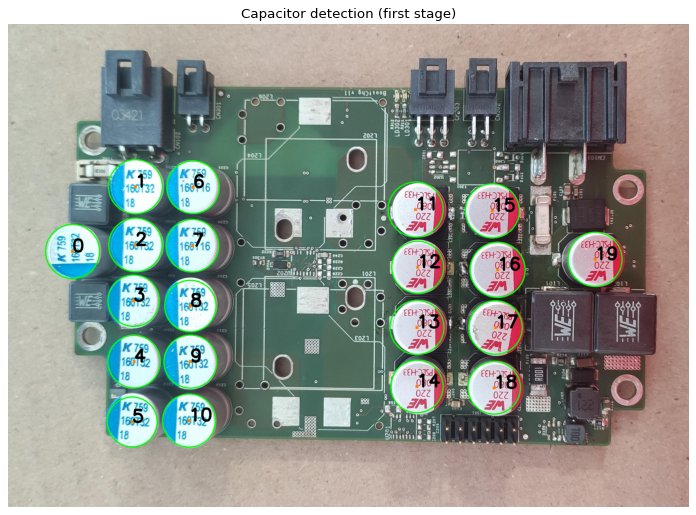

Number of capacitors detected: 20


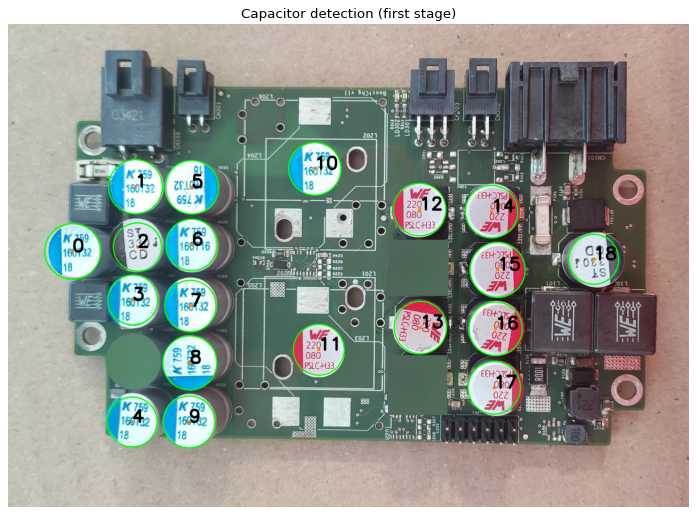

Number of capacitors detected: 19


In [ ]:
circular_bb_display(ground_truth_image)
circular_bb_display(new_image)

In [ ]:
new_image_capacitor_info = check_capacitors(new_image, ground_truth_image, polarity_ref_blue, polarity_ref_red)
new_image_capacitor_info[0]

0-capacitor_index (test)  ...  10-abs_degree
0                        0.0  ...            NaN
1                        1.0  ...            4.0
2                        2.0  ...            NaN
3                        3.0  ...            5.0
4                        4.0  ...            9.0
5                        5.0  ...            NaN
6                        6.0  ...            2.0
7                        7.0  ...            2.0
8                        8.0  ...            NaN
9                        9.0  ...            1.0
17                      10.0  ...            NaN
18                      11.0  ...            NaN
10                      12.0  ...            NaN
11                      13.0  ...            NaN
12                      14.0  ...            3.0
13                      15.0  ...            1.0
14                      16.0  ...           11.0
15                      17.0  ...            3.0
16                      18.0  ...            NaN
19                       NaN  ...            NaN
20                       NaN  ...            NaN
21                       NaN  ...            NaN

[22 rows x 11 columns]

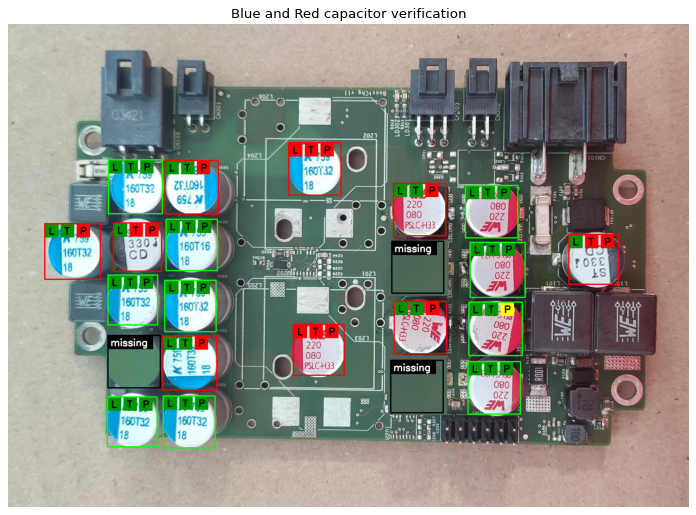

In [ ]:
check_capacitors_display(new_image, ground_truth_image, polarity_ref_blue, polarity_ref_red)

## **6) Results**

The project allows to reach all the defined specifications. 

The function used for inspection has four arguments, all images, namely: a *ground truth image*, an *image with the PCB to inspect*, and two reference images, one for the blue and one for the red capacitors.

The **output of the algorithm** is the **annotated image of the PCB to inspect**, with green, red and black bounding boxes:
* **Green bounding box** indicates that the component is **in compliance**;
* **Red bounding box** indicates that the component is **incorrect**;
* **Black bounding box** indicates that the component is **missing**. 

The green and red bounding boxes include smaller boxes, labeled **L** for location, **T** for type, and **P** for polarity. If all is correct, all of these smaller boxes are green (*). If an issue is detected, the corresponding smaller box changes to red. The reasons that lead to this change in classification are: 
* Incorrect location (red L box) - the capacitor is placed at the wrong position of the PCB;
* Incorrect type (red T box) - the capacitor is placed in the correct position but it is the wrong type (e.g., a red capacitor is placed in place of a blue capacitor);
* Incorrect polarity (red P box) - this last indicator means that the capacitor is in the correct place and is of the correct type but with the wrong polarity.

(*) An additional feature was included to allow for a more detailed inspection. Specifically, if the polarity is correct but has a significant deviation from the ideal position, about 10 degrees (allows adjustment), the corresponding P box will be highlighted in yellow, to suggest an inspection.

**Below, all six PCB images are tested against the gound truth image, and the annotated image is presented.**

In [ ]:
# Image 1
new_image = original_images[1]
check_capacitors_display(new_image, ground_truth_image, polarity_ref_blue, polarity_ref_red)

# Image 2
new_image = original_images[2]
check_capacitors_display(new_image, ground_truth_image, polarity_ref_blue, polarity_ref_red)

# Image 3
new_image = original_images[3]
check_capacitors_display(new_image, ground_truth_image, polarity_ref_blue, polarity_ref_red)

# Image 4
new_image = original_images[4]
check_capacitors_display(new_image, ground_truth_image, polarity_ref_blue, polarity_ref_red)

# Image 5
new_image = original_images[5]
check_capacitors_display(new_image, ground_truth_image, polarity_ref_blue, polarity_ref_red)

# Image 6
new_image = original_images[6]
check_capacitors_display(new_image, ground_truth_image, polarity_ref_blue, polarity_ref_red)

Output hidden; open in https://colab.research.google.com to view.

The table below lists the nonconformity in the images (the numbering of the images follows the order of the annotated images presented). **As can be seen in the annotated images above, in every one of them, all nonconformity are correcly annotated.**

| Changes to the ground truth image | Image 1 | Image 2 | Image 3 | Image 4 | Image 5 | Image 6 |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|
| Missing capacitor | 0 | 0 | 1 | 3 | 2 | 1 |
| Additional big capacitor | 0 | 1 | 0 | 2 | 1 | 1 |
| Correct location <br> Wrong type | 0 | 0 | 2 | 2 | 3 | 3 |
| Correct location <br> Correct type <br> Wrong polarity| 0 | 0 | 1 | 5 | 2 | 2 |


## **7) Discussion of results, benchmarking, and final considerations**

In this project, **the objective was to detect nonconformities regarding two specific capacitors in a PCB image, given a correct (i.e., ground truth) PCB image**.

This goal was divided into **four sequential tasks** and implement in the algorithm: **1) detection; 2) location check; 3) type check; 4) polarity check**.

Six images (2 original and 4 manipulated) with nonconformity were used to assess the algorithm. **All the types of nonconformities were accurately detected in the test images.** The annotated image that is outputted by the algorithm allows for an easy nonconformity identification.

Despite the fact that some images had to be manipulated to introduce more variability, we believe that the algorithm is robust enough to identify nonconformities using a different set of PCB images, if the distance between the camera and PCB is preserved, all PCB in the same set are placed at the same location on the surface, and if the image resolution also preserved. This is not a relevant limitation in this particular quality assurance context, since it is easy to maintain the setup were the images are taken.

Naturally, some improvements can be made or, at least, tested. For example, it would be interesting to explore the possibility of using keypoints exclusively for all four tasks, given that reference images for each capacitor type are provided. However, the relevance of some possible modifications is highly dependent on additional more detailed requeriments. For example, if many images are compared with the same ground truth PCB, then the ground truth feature extraction should be done separately, as a preliminary step and these features used as input. Also, if the nonconformities variations can all be identified, then some steps in the algorithm might not have to be so generic, like capacitor detection anywhere in the PCB.

Comparing this project to somewhat related projects, one paper stands out, namely: 

> Y.L. Lin, Y.M. Chiang and H.C. Hsu, "**Capacitor Detection in PCB Using YOLO Algorithm**," 2018 International Conference on System Science and Engineering (ICSSE), 2018, pp. 1-4, doi: [10.1109/ICSSE.2018.8520170](https://ieeexplore.ieee.org/document/8520170).

In this paper, the authors train YOLO algorithm, which is based in a CNN, to detect nine types of capacitors on PCB. The figure below is an example of an annotated image presented in the paper.

<center>

![Legend](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT3PSY5VDnzULMhfdA2S68yUwlmwqKkghZoqDjkiSm8UhGSMJHaTgQSHYcuLvaA_h_kxEs&usqp=CAU)

**Figure.** The capacitor detection results of a test image in Lin, Chiang and Hsu (2018)

</center>

It can be seen that, in relation to our project, only detection and type analysis are implemented, which excludes polarity analysis and comparison against ground truth. Due to this fact, runtime comparison is not possible without significative changes to our algorithm.

However, it is interesting to analyze the authors approach to the tasks that overlap our project tasks.

* The authors argue that no experts are needed to define image features. That is true, but it is also true that experts are needed to annotate the images and then train and test YOLO.

* YOLO is a very interesting approach to detect objects that present high variability in the images. In this case, images are always collected in a very specific way (PCB directly underneath
the camera) and there are only a few capacitor types to identify. Thus this approach is somewhat exaggerated in this case.

* Also, any new capacitor would, probably, take more time and would need far more images to include as a YOLO class (since the model would have to be retrained) than with a more direct approach like ours.

Hence, we believe that this project is a viable starting point for quality assurance tester of PCB.